In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bgflow.utils import (assert_numpy, distance_vectors, distances_from_vectors, 
                          remove_mean, IndexBatchIterator, LossReporter, as_numpy, compute_distances
)
from bgflow import (GaussianMCMCSampler, DiffEqFlow, BoltzmannGenerator, Energy, Sampler, 
                    MultiDoubleWellPotential, MeanFreeNormalDistribution, KernelDynamics)
from tbg.models2 import EGNN_dynamics_AD2, EGNN_dynamics_AD2_cat
import ot as pot
import time
from bgmol.datasets import AImplicitUnconstrained
import mdtraj as md
from matplotlib.colors import LogNorm
from tbg.utils import create_adjacency_list, find_chirality_centers, compute_chirality_sign, check_symmetry_change
import tqdm
import scipy

In [3]:
dataset = AImplicitUnconstrained(read=True, download=True)
n_particles = 22
n_dimensions = 3
scaling = 10
dim = n_particles * n_dimensions

  0%|          | 0/472141053 [00:00<?, ?it/s]

Extracting /storage/mi/leoma/libraries/en_flows_code/tbg/AImplicitUnconstrained.tgz to /storage/mi/leoma/libraries/en_flows_code/tbg
Using downloaded and verified file: /tmp/A.pdb


In [4]:
data = dataset.xyz

In [5]:
target = dataset.get_energy_model()
data_energies = target.energy(torch.from_numpy(dataset.xyz[::10].reshape(-1,66)))

/storage/mi/leoma/libraries/bgflow/bgflow/distribution/energy/openmm.py:200: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


In [6]:
ala_traj = md.Trajectory(dataset.xyz, dataset.system.mdtraj_topology)
phi = md.compute_phi(ala_traj)[1].flatten()
psi = md.compute_psi(ala_traj)[1].flatten()

In [7]:
len(np.where((phi>0.5)&(phi<2))[0])/ len(phi)

0.006989

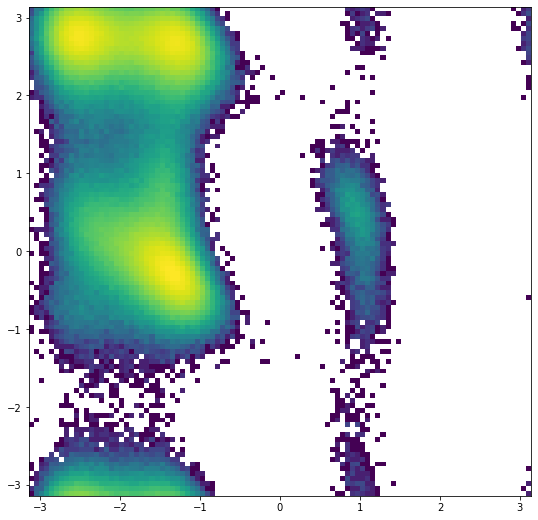

In [8]:
plt.figure(figsize=(9,9))
plt.hist2d(phi, psi, bins=100, norm=LogNorm());

In [14]:
npz_file = np.load(f"/result_data/ad2_tbg_full.npz")
#npz_file = np.load(f"/result_data/ad2_tbg_backbone.npz")

latent_np=npz_file["latent_np"]
samples_np=npz_file["samples_np"]
dlogp_np=npz_file["dlogp_np"]


In [15]:
dlogp_np.shape

(195600,)

In [16]:
import networkx.algorithms.isomorphism as iso
import networkx as nx
from networkx import isomorphism


def align_topology(sample, reference, scaling=scaling):
    sample = sample.reshape(-1, 3)
    all_dists = scipy.spatial.distance.cdist(sample, sample)
    adj_list_computed = create_adjacency_list(all_dists/scaling, atom_types)
    G_reference = nx.Graph(reference)
    G_sample = nx.Graph(adj_list_computed)
    # not same number of nodes
    if len(G_sample.nodes) != len(G_reference.nodes):
        return sample, False
    for i, atom_type in enumerate(atom_types):
        G_reference.nodes[i]['type']=atom_type
        G_sample.nodes[i]['type']=atom_type
        
    nm = iso.categorical_node_match("type", -1)
    GM = isomorphism.GraphMatcher(G_reference, G_sample, node_match=nm)
    is_isomorphic = GM.is_isomorphic()
    # True
    GM.mapping
    initial_idx = list(GM.mapping.keys())
    final_idx = list(GM.mapping.values())
    sample[initial_idx] = sample[final_idx]
    #print(is_isomorphic)
    return sample, is_isomorphic

In [17]:
atom_dict = {"C": 0, "H":1, "N":2, "O":3}
#["C", "H", "N", "O", "S"]
topology = dataset.system.mdtraj_topology
atom_types = []
for atom_name in topology.atoms:
    atom_types.append(atom_name.name[0])
atom_types = torch.from_numpy(np.array([atom_dict[atom_type] for atom_type in atom_types]))
adj_list = torch.from_numpy(np.array([(b.atom1.index, b.atom2.index) for b in topology.bonds], dtype=np.int32))

In [25]:
aligned_samples = []
aligned_idxs = []

for i, sample in tqdm.tqdm(enumerate(samples_np.reshape(-1,dim//3, 3))):   
    aligned_sample, is_isomorphic = align_topology(sample, as_numpy(adj_list).tolist())
    if is_isomorphic:
        aligned_samples.append(aligned_sample)
        aligned_idxs.append(i)
aligned_samples = np.array(aligned_samples)
aligned_samples.shape
print(f"Correct configuration rate {len(aligned_samples)/len(samples_np)}")

195600it [09:35, 339.63it/s]


Correct configuration rate 0.9993302658486708


In [26]:
import nglview as nv

traj_samples = md.Trajectory(aligned_samples/scaling, topology=topology)
nv.show_mdtraj(traj_samples)

NGLWidget(max_frame=195468)

In [27]:
phis = md.compute_phi(traj_samples)[1].flatten()
psis = md.compute_psi(traj_samples)[1].flatten()


In [28]:
model_samples = torch.from_numpy(traj_samples.xyz)
chirality_centers = find_chirality_centers(adj_list, atom_types)
reference_signs = compute_chirality_sign(torch.from_numpy(data.reshape(-1, dim//3, 3))[[1]], chirality_centers)
symmetry_change = check_symmetry_change(model_samples, chirality_centers, reference_signs)
model_samples[symmetry_change] *=-1
symmetry_change = check_symmetry_change(model_samples, chirality_centers, reference_signs)


In [29]:
print(f"Correct symmetry rate {(~symmetry_change).sum()/len(model_samples)}")


Correct symmetry rate 1.0


Text(0, 0.5, 'Free energy / $k_B T$')

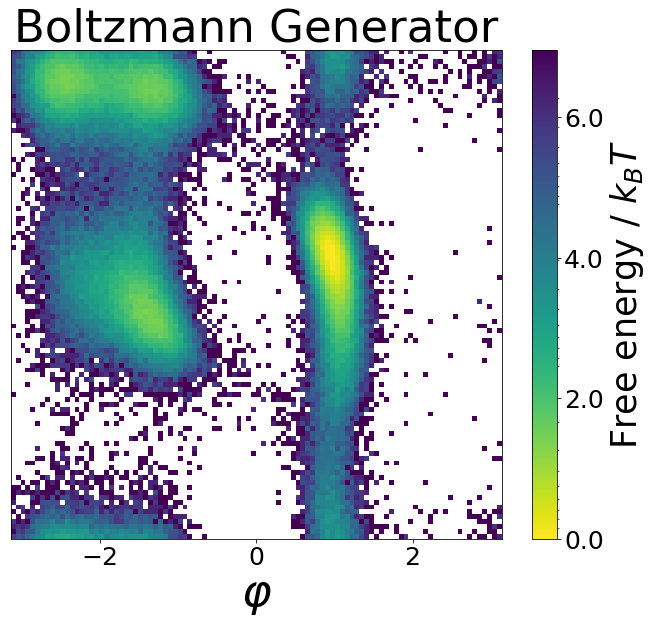

In [30]:
traj_samples = md.Trajectory(as_numpy(model_samples)[~symmetry_change], topology=topology)

phis = md.compute_phi(traj_samples)[1].flatten()
psis = md.compute_psi(traj_samples)[1].flatten()


fig, ax = plt.subplots(figsize=(11, 9))
plot_range = [-np.pi, np.pi]

h, x_bins, y_bins, im = ax.hist2d(phis, psis, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel(r"$\varphi$", fontsize=45)
ax.set_title("Boltzmann Generator", fontsize=45)
#ax.set_ylabel(r"$\psi$", fontsize=45)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.yaxis.set_ticks([])

cbar = fig.colorbar(im, ticks=ticks)
#cbar.ax.set_yticklabels(np.abs(-np.log(ticks/h.max())), fontsize=25)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=25)

cbar.ax.invert_yaxis()
cbar.ax.set_ylabel(r"Free energy / $k_B T$", fontsize=35)


In [31]:
classical_model_energies = as_numpy(target.energy(model_samples.reshape(-1, dim)[~symmetry_change]))
classical_target_energies = as_numpy(target.energy(torch.from_numpy(data[::10]).reshape(-1, dim)))

In [33]:
prior = MeanFreeNormalDistribution(dim, n_particles, two_event_dims=False).cuda()
idxs = np.array(aligned_idxs)[~symmetry_change]
log_w_np = -classical_model_energies + as_numpy(prior.energy(torch.from_numpy(latent_np[idxs]).cuda())) + dlogp_np.reshape(-1,1)[idxs]

In [34]:
from bgflow.bg import sampling_efficiency
sampling_efficiency(torch.from_numpy(log_w_np)).item()

0.07459232764655059

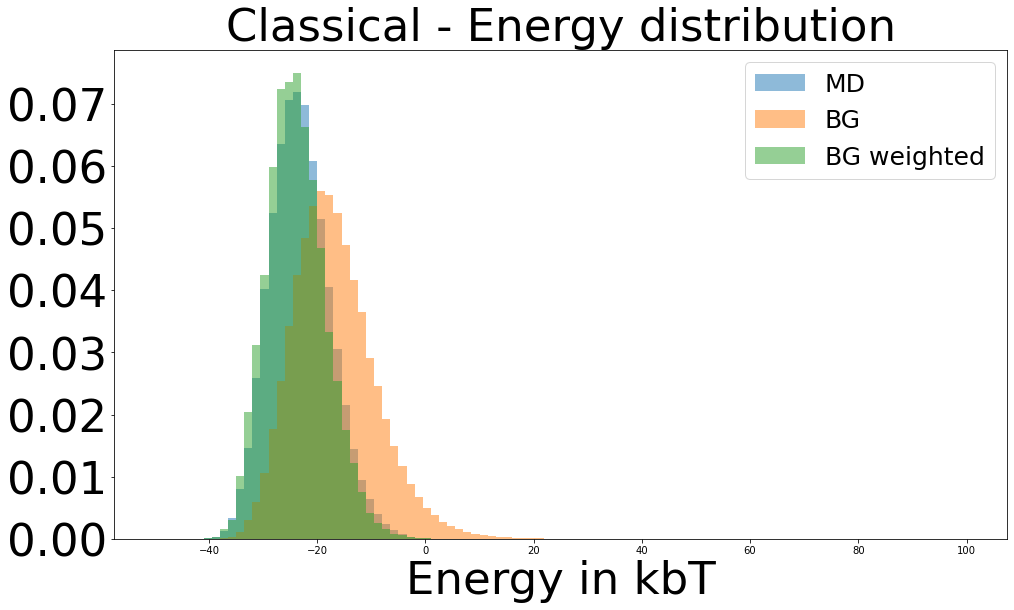

In [35]:
plt.figure(figsize=(16,9))

plt.hist(classical_target_energies, bins=100, alpha=0.5, range=(-50,100), density=True, label="MD");
plt.hist(classical_model_energies, bins=100,alpha=0.5, range=(-50,100), density=True, label="BG");
plt.hist(classical_model_energies, bins=100,alpha=0.5, range=(-50,100), density=True, label="BG weighted", weights=np.exp(log_w_np));

plt.legend(fontsize=25)
plt.xlabel("Energy in kbT", fontsize=45)  
plt.yticks(fontsize=45);
plt.title("Classical - Energy distribution", fontsize=45);

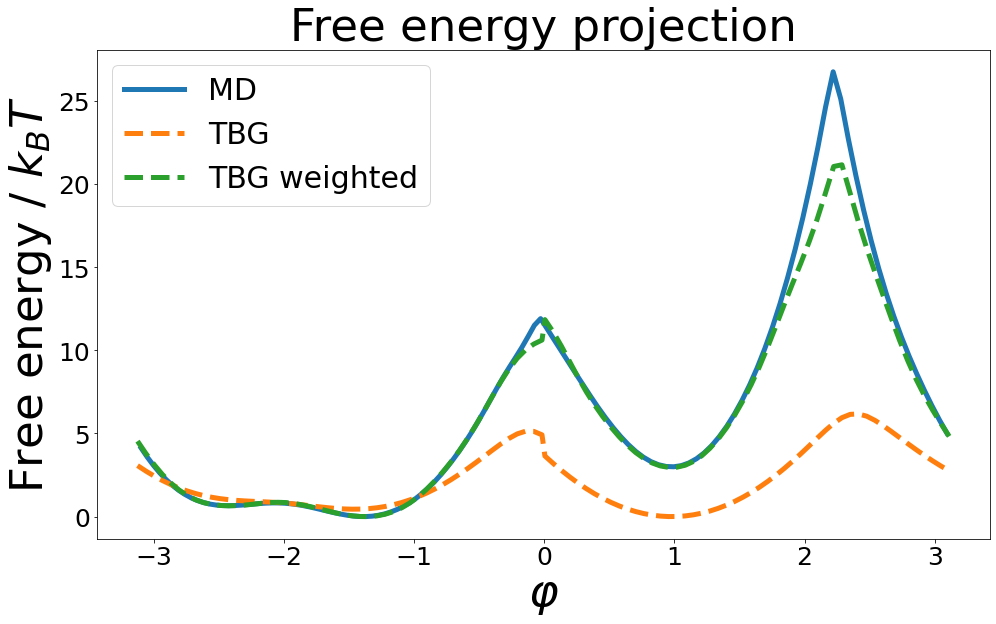

In [36]:
traj_data = md.Trajectory(dataset.xyz[800000:], topology=topology)
phis_data = md.compute_phi(traj_data)[1].flatten()
psis_data = md.compute_psi(traj_data)[1].flatten()

def plot_fes(
    samples: np.ndarray,
    bw_method:  None,
    weights: None,
    get_DeltaF: bool = True,
    kBT: float = 1.0,
):
    from scipy.stats import gaussian_kde
    bw_method =0.18# "scott"

    grid = np.linspace(samples.min(), samples.max(), 100)
    fes = -kBT * gaussian_kde(samples, bw_method, weights).logpdf(grid)
    fes -= fes.min()

    return grid, fes
phi_right = phis_data.copy()
phi_left = phis_data.copy()
phi_right[phis_data<0] += 2*np.pi
phi_left[phis_data>np.pi/2] -= 2*np.pi       

#plot_fes(phi,bw_method=None, weights=np.exp(log_w_np),get_DeltaF=False)
grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=None, get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=None, get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left_data  = grid_left[idx_left]
fes_left_data  = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right_data  = grid_right[idx_right]
fes_right_data  = fes_right[idx_right]


phi_right = phis.copy()
phi_left = phis.copy()
phi_right[phis<0] += 2*np.pi
phi_left[phis>np.pi/2] -= 2*np.pi       

#plot_fes(phi,bw_method=None, weights=np.exp(log_w_np),get_DeltaF=False)
grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=None, get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=None, get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left = grid_left[idx_left]
fes_left = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right = grid_right[idx_right]
fes_right = fes_right[idx_right]

plt.figure(figsize=(16,9))
plt.plot(np.hstack([grid_left_data, grid_right_data]), np.hstack([fes_left_data, fes_right_data]), linewidth=5, label="MD")
plt.plot(np.hstack([grid_left, grid_right]), np.hstack([fes_left, fes_right]), linewidth=5, linestyle="--", label="TBG")

phi_right = phis.copy()
phi_left = phis.copy()
phi_right[phis<0] += 2*np.pi
phi_left[phis>np.pi/2] -= 2*np.pi       

#plot_fes(phi,bw_method=None, weights=np.exp(log_w_np),get_DeltaF=False)
grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=np.exp(log_w_np).flatten(), get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=np.exp(log_w_np).flatten(), get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left = grid_left[idx_left]
fes_left = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right = grid_right[idx_right]
fes_right = fes_right[idx_right]
plt.plot(np.hstack([grid_left, grid_right]), np.hstack([fes_left, fes_right]), linewidth=5, linestyle="--", label="TBG weighted")


plt.title(f"AD2 phi distribution", fontsize=45);
plt.legend(fontsize=30);
plt.title("Free energy projection", fontsize=45)
plt.xlabel(r"$\varphi$", fontsize=45)
plt.ylabel("Free energy / $k_B T$", fontsize=45)
plt.xticks(fontsize=25);
plt.yticks(fontsize=25);
